<span>
<img src="http://ndlib.readthedocs.io/en/latest/_static/ndlogo2.png" width="260px" align="right"/>
</span>
<span>
<b>Authors:</b> Salvatore Citraro, <a href="http://about.giuliorossetti.net">Giulio Rossetti</a>, Letizia Milli<br/>
<b>Python version:</b>  3.7<br/>
<b>NDlib version:</b>  5.0.2<br/>
<b>Last update:</b> 29/04/2020
</span>

<a id='top'></a>

# UTLDR: an agent-based framework for modeling infectious diseases and public interventions

UTLDR is an agent-based, stochastic, frameworks that can be used to simulate the effect of alternative combinations of public interventions.

UTLDR name is an acronym of the "meta-compartments" that compose it: **U**ndetected - **T**ested - **L**ockdown - **D**ead - **R**ecovered.

It requires as input a population of agents (preferibly characterized by age/gender as well as working place) tied in a social tissue (it is not a mean field approach). <br>
Household structures as well as schools, workingplaces and other social circles are assumend to be embedded within the social network and annotated at agent level.

In [2]:
import networkx as nx

#ndlib - configuration and model
from ndlib.models import ModelConfig as mc
from ndlib.models import epidemics as ep

#ndlib - visualization
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
%matplotlib inline

In [3]:
# Network topology (can be either a networkx or an igraph object)
g = nx.barabasi_albert_graph(1000, 6)

## 1) Modeling scenarios

The proposed model can be seen as a modular interface to perform what-if analysis by combining standard strategies for epidemic containment.

In the following we report a few examples to show how Testing/Hospitalization & Lockdown can be enforced in the model as well as discuss advanced features such as agents stratification and characterization.

Each scenario will be named using an acronym of the "meta-compartments" composing it.

In [6]:
# Model selection
model = ep.UTLDRModel(g)

# Available Compartments in the framework
model.available_statuses

{'Susceptible': 0,
 'Exposed': 2,
 'Infected': 1,
 'Recovered': 3,
 'Identified_Exposed': 4,
 'Hospitalized_mild': 5,
 'Hospitalized_severe_ICU': 6,
 'Hospitalized_severe': 7,
 'Lockdown_Susceptible': 8,
 'Lockdown_Exposed': 9,
 'Lockdown_Infected': 10,
 'Dead': 11,
 'Vaccinated': 12}

<a id='0'></a>
### a) Base model SEIR (Undetected) ([to top](#top))

<img src="img/SEIR.png" align="center" />

UTLDR builds upon a standard SEIR model (that in the following scenario will be used to describe the "undetected" epidemic diffusion).

The SEIR model was introduced in 1984 in order to investigate the role of seasonality in  cycles of recurrent epidemics. 
We can suppose that a population can assume four states:

- Susceptible (S): those individuals able to contract the disease
- Exposed (E): those who have been infected but are not yet infectious
- Infected (I): those capable of transmitting the disease
- Recovered (R): those who have become immune or deceased

Indeed, many diseases have a latent phase during which the individual is infected but not yet infectious. <br>
This delay between the acquisition of infection and the infectious state can be incorporated within the SIR model by adding a latent/exposed population, E, and letting infected (but not yet infectious) individuals move from S to E and from E to I.

SEIR assumes that if, during a generic iteration, a susceptible node comes into contact with an infected one, it becomes infected after an exposition period ($1/\sigma$) with probability $\beta$, then it can switch to removed with probability $\gamma$ (the only transitions allowed are S$\rightarrow$E$\rightarrow$I$\rightarrow$R).

100%|██████████| 150/150 [00:02<00:00, 62.87it/s] 


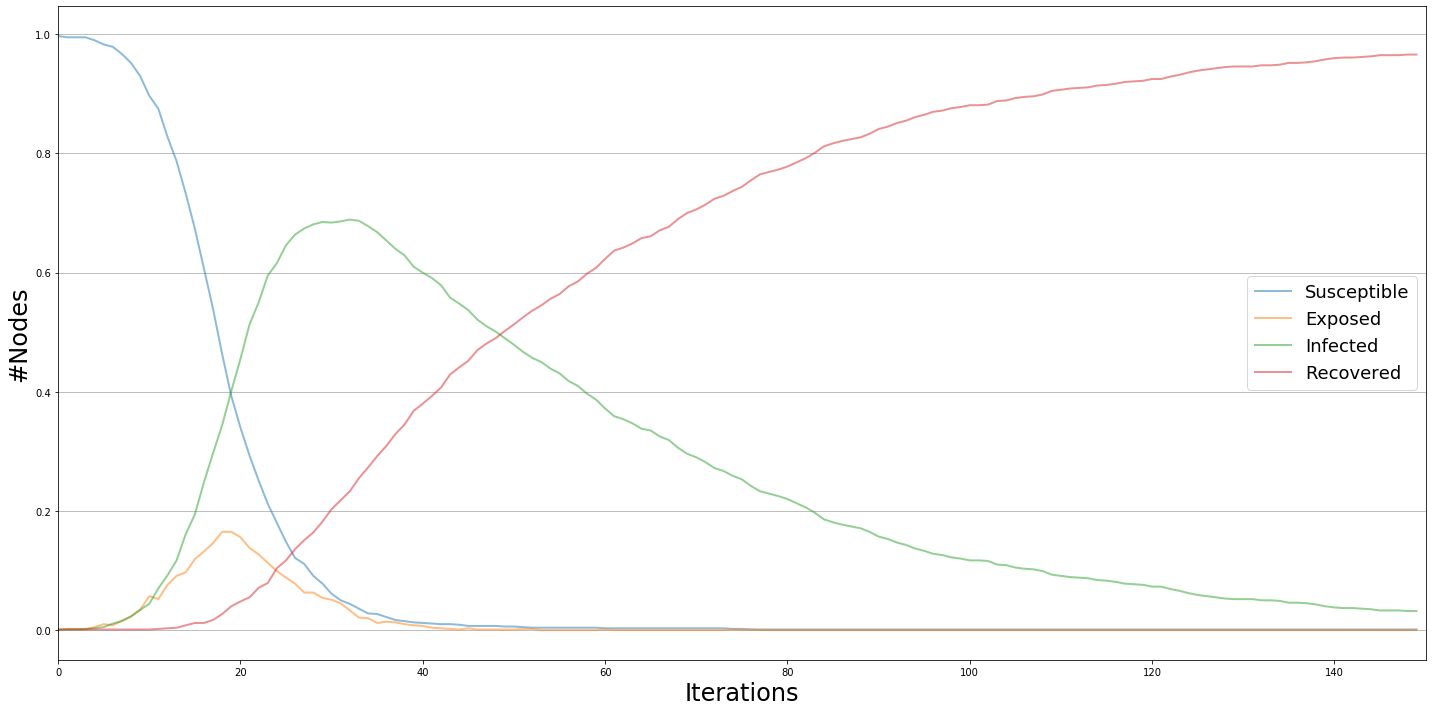

In [9]:
# Baseline Model Configuration
cfg = mc.Configuration()
beta, sigma, gamma = 0.04, 0.4, 1/40
init_infected, number_iters = 0.0001, 150

cfg.add_model_parameter('beta', beta) 
cfg.add_model_parameter('sigma', sigma)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter("fraction_infected", init_infected) 

model.set_initial_status(cfg)
    
# Simulation execution
it = model.iteration_bunch(number_iters)
trends = model.build_trends(it)

# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=['Susceptible', 'Exposed', 'Infected', 'Recovered']) # no recovered-dead distinction

### b) Separating recovered from dead: UDR ([to top](#top))

<img src="img/SEIRD.png" align="center" />

In this scenario we differentiate the final outcome of infection evolution in two terminal compartments: Recovered (with immunity) and Dead.

100%|██████████| 150/150 [00:03<00:00, 49.09it/s] 


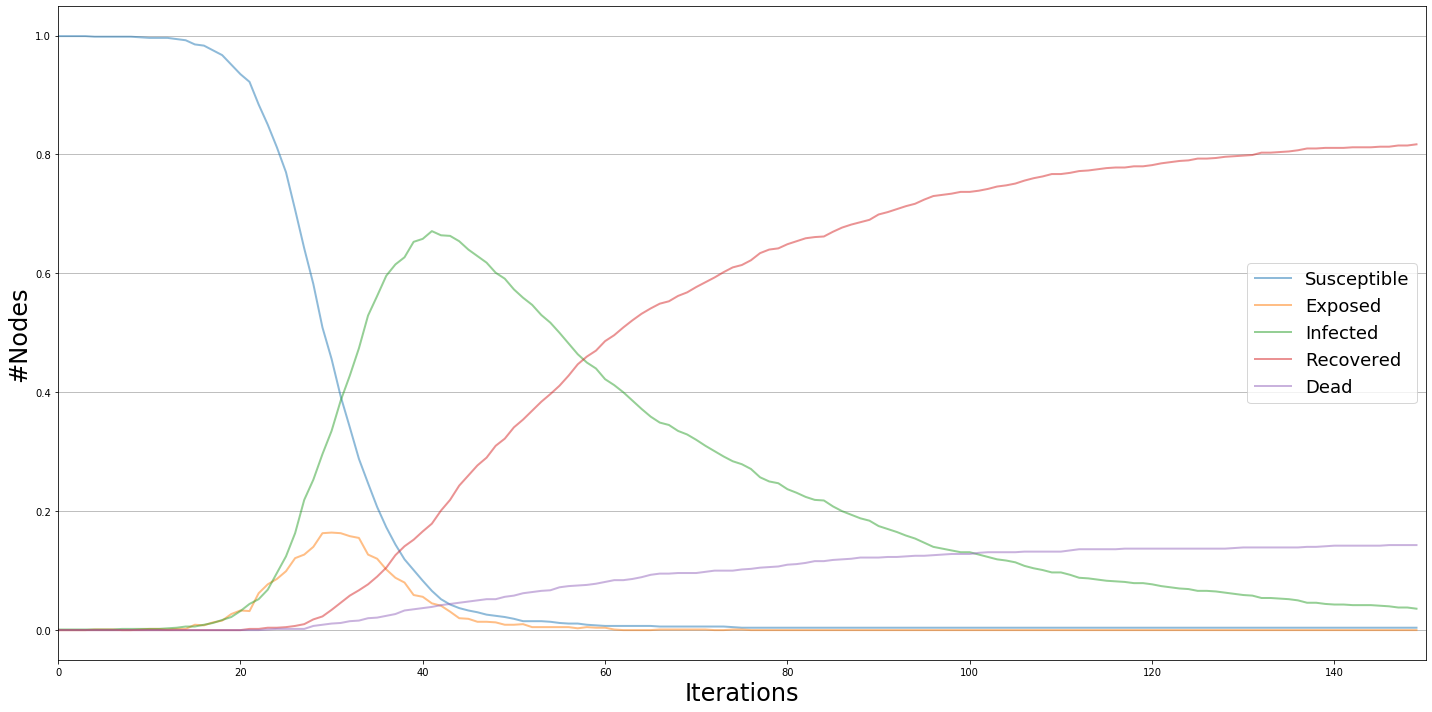

In [15]:
# Model selection
model = ep.UTLDRModel(g)

# Baseline Model Configuration
cfg = mc.Configuration()
beta, sigma, gamma, omega = 0.04, 0.4, 1/40, 0.005
init_infected, number_iters = 0.0001, 150

cfg.add_model_parameter('beta', beta) 
cfg.add_model_parameter('sigma', sigma)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter("omega", omega) # death probability

cfg.add_model_parameter("fraction_infected", init_infected) 

model.set_initial_status(cfg)
    
# Simulation execution
it = model.iteration_bunch(number_iters)
trends = model.build_trends(it)

# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Dead']) # no recovered-dead distinction

<a id='0'></a>
### c) Introducing Testing & Hospitalization: UTDR ([to top](#top))

<img src="img/UTDR.png" align="center" />

Testing can be performed on exposed and infected agents with probability $\vartheta_E$ and $\vartheta_I$ respectively.<br>

A positive test result (having probability $\kappa_E$ and $\kappa_I$ to result in a false negative) moves an agent into the appropriate detected state, $E_T$  and $I_T$ 

When an agent is quarantined its sociality is affected by a factor $\epsilon_E$.

A ratio $\epsilon_E$ of the ties of positive tested agents are pruned due to quarantine.<br>

100%|██████████| 150/150 [00:05<00:00, 25.14it/s]


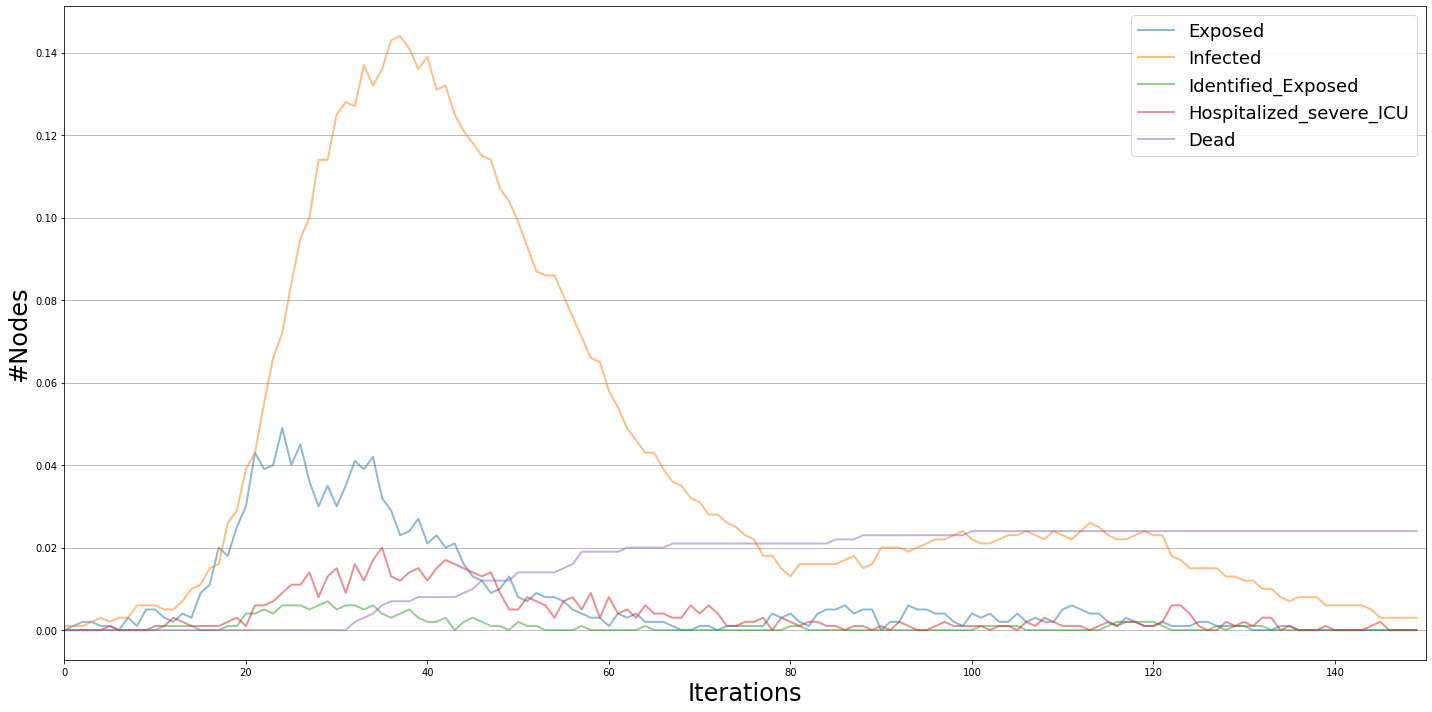

In [21]:
# Model selection
model = ep.UTLDRModel(g)

# Baseline Model Configuration
cfg = mc.Configuration()
beta, sigma, gamma, omega = 0.04, 0.4, 1/40, 0.005
epsilon_e, phi_e, kappa_e, phi_i, kappa_i = 0.9, 0.05, 0.01, 0.05, 0.01
init_infected, number_iters = 0.0001, 150

cfg.add_model_parameter('beta', beta) 
cfg.add_model_parameter('sigma', sigma)
cfg.add_model_parameter('gamma', gamma)

# death probability
cfg.add_model_parameter("omega", omega) 

# Sociality filter due to quarantine
cfg.add_model_parameter("epsilon_e", epsilon_e)
    
# Test Exposed
cfg.add_model_parameter("phi_e", phi_e)
cfg.add_model_parameter("kappa_e", kappa_e)
    
# Test Infected
cfg.add_model_parameter("phi_i", phi_i)
cfg.add_model_parameter("kappa_i", kappa_i)


cfg.add_model_parameter("fraction_infected", init_infected) 

model.set_initial_status(cfg)
    
# Simulation execution
it = model.iteration_bunch(number_iters)
trends = model.build_trends(it)

# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=['Exposed', 'Infected', 'Dead', 'Identified_Exposed', 'Hospitalized_severe_ICU']) 

<a id='0'></a>
### d) Modeling Infection Severity and ICU Limitations: UTDR + ICU ([to top](#top))

<img src="img/UTDR-ICU.png" align="center" />

This variant extend the previous scenario by differentiating the severity of infection in two classes: mild and severe.

After a positive test, an agent can be assigned to one of the two classes ($I_T$ mild, and $H_T$ severe) upon probability $\iota$

Moreover, to model limited availability in ICU for severe illed agents the number of beds can be specified $icu_b$.<br>
When no more beds in ICU are available severe patient are allocated in a separate state, $F$, that accounts for a different dead/recovery rate.

100%|██████████| 150/150 [00:06<00:00, 24.54it/s]


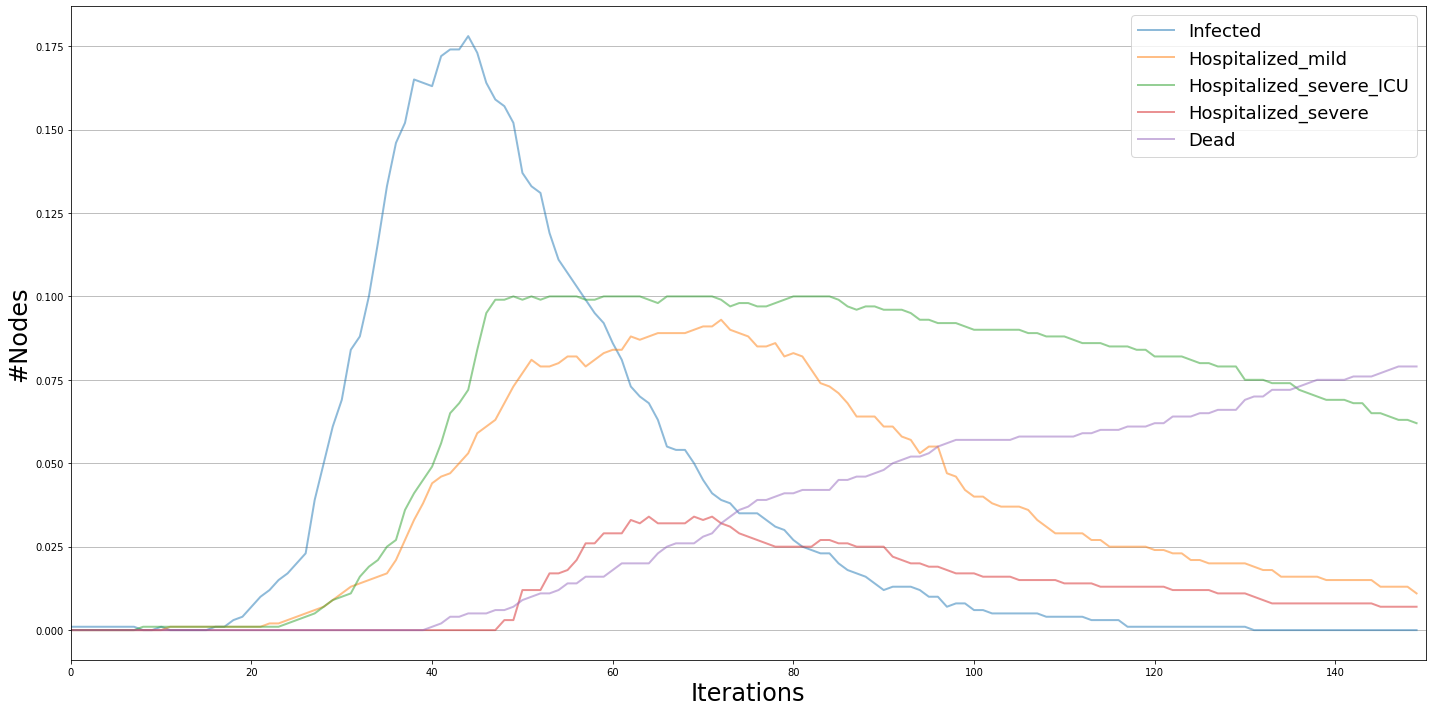

In [30]:
# Model selection
model = ep.UTLDRModel(g)

# Baseline Model Configuration
cfg = mc.Configuration()
beta, sigma, gamma, omega = 0.04, 0.4, 1/40, 0.005
epsilon_e, phi_e, kappa_e, phi_i, kappa_i = 0.9, 0.05, 0.01, 0.05, 0.01
init_infected, number_iters = 0.0001, 150
icu_b = 100 # Available beds
iota = 0.5

# tested recovery rate
gamma_f, gamma_t = 1/200, 1/200

# tested death rate
omega, omega_f, omega_t = 1/1000, 1/50, 1/400

cfg.add_model_parameter('beta', beta) 
cfg.add_model_parameter('sigma', sigma)
cfg.add_model_parameter('gamma', gamma)

# death probability
cfg.add_model_parameter("omega", omega) 

# Sociality filter due to quarantine
cfg.add_model_parameter("epsilon_e", epsilon_e)
    
# Test Exposed
cfg.add_model_parameter("phi_e", phi_e)
cfg.add_model_parameter("kappa_e", kappa_e)
    
# Test Infected
cfg.add_model_parameter("phi_i", phi_i)
cfg.add_model_parameter("kappa_i", kappa_i)

# ICU and hospitalized death/recovery rate
cfg.add_model_parameter("icu_b", icu_b)  # Available beds in ICU
cfg.add_model_parameter("iota", iota)  # Probability of a severe infection needing ICU
cfg.add_model_parameter("gamma_f", gamma_f)
cfg.add_model_parameter("gamma_t", gamma_t)
cfg.add_model_parameter("omega_f", omega_f)
cfg.add_model_parameter("omega_t", omega_t)

cfg.add_model_parameter("fraction_infected", init_infected) 

model.set_initial_status(cfg)
    
# Simulation execution
it = model.iteration_bunch(number_iters)
trends = model.build_trends(it)

# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=['Infected', 'Hospitalized_mild', 'Hospitalized_severe', 'Hospitalized_severe_ICU', 'Dead']) 

<a id='0'></a>
### e) Modeling Lockdowns: ULDR ([to top](#top))

<img src="img/ULDR.png" align="center" />

In this scenario we model lockdown intervention.

Lockdown is regulated by two parameters: $\lambda$ the compliancy probability and $\mu$ the expected duration of the lockdown.

Durining lockdown the sociality of agents is limited to their households (if specified) or to a fraction $\epsilon_l$ of their contacts.

/home/rossetti/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:120: UserWarning: Initial infection missing: a random sample of 5% of graph nodes will be set as infected
  warnings.warn('Initial infection missing: a random sample of 5% of graph nodes will be set as infected')
100%|██████████| 120/120 [00:01<00:00, 119.47it/s]


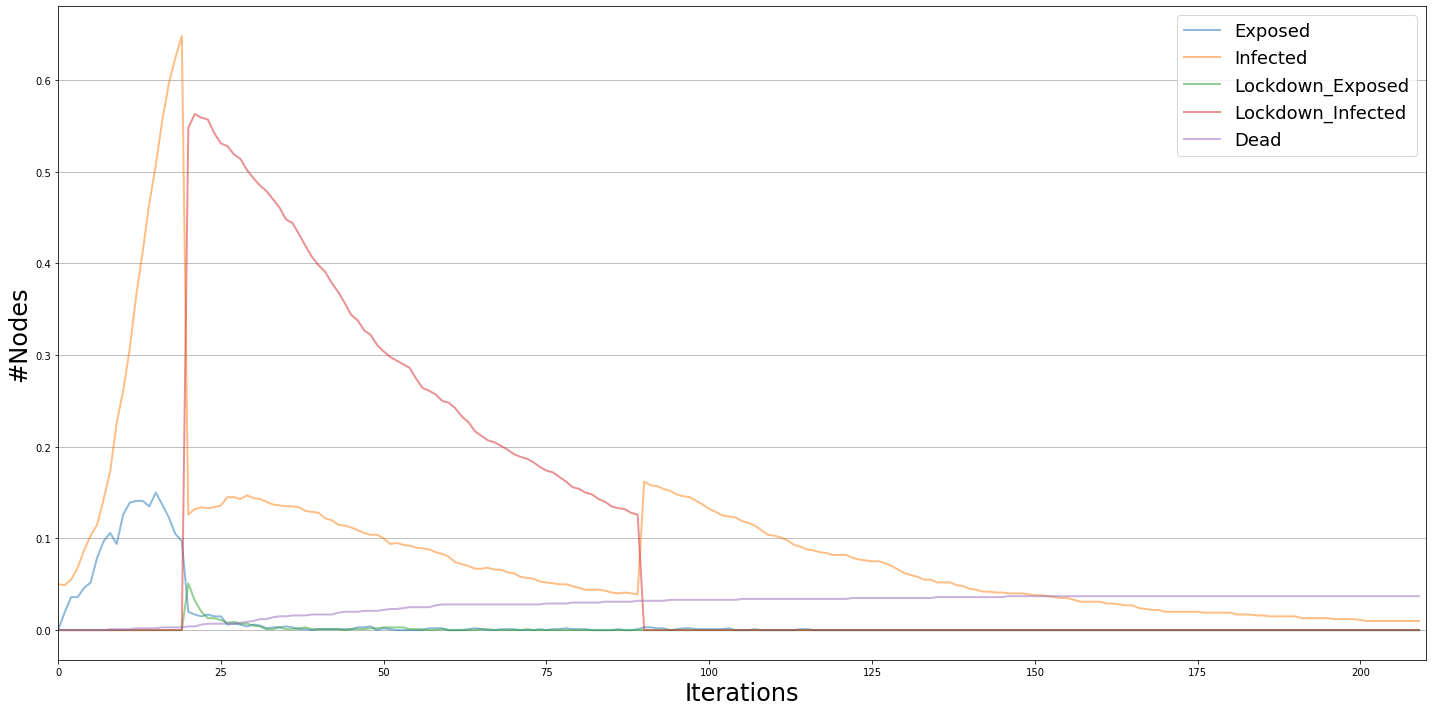

In [23]:
# Model selection
model = ep.UTLDRModel(g)

# Baseline Model Configuration
cfg = mc.Configuration()
beta, sigma, gamma, omega = 0.04, 0.4, 1/40, 0.005
epsilon_e, phi_e, kappa_e, phi_i, kappa_i = 0.9, 0.05, 0.01, 0.05, 0.01
init_infected, number_iters = 0.0001, 150

# tested recovery rate
gamma_f, gamma_t = 1/200, 1/200

# tested death rate
omega, omega_f, omega_t = 1/1000, 1/50, 1/400

# lockdown
epsilon_l, p_l, lmbd, mu = 3, 0.01, 0.8, 1/70

cfg.add_model_parameter('beta', beta) 
cfg.add_model_parameter('sigma', sigma)
cfg.add_model_parameter('gamma', gamma)

# death probability
cfg.add_model_parameter("omega", omega) 


# Lockdown parameters
cfg.add_model_parameter("epsilon_l", epsilon_l)
    
# Interactions, acceptance & duration
cfg.add_model_parameter("lambda", lmbd)
cfg.add_model_parameter("mu", mu)
    
model.set_initial_status(cfg)
    
# Simulation execution
it = model.iteration_bunch(20)

model.set_lockdown()
it2 = model.iteration_bunch(70)

model.unset_lockdown()
it3 = model.iteration_bunch(120)

it.extend(it2)
it.extend(it3)
trends = model.build_trends(it)

# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=['Infected', 'Exposed', 'Lockdown_Exposed', 'Lockdown_Infected', 'Dead']) # no recovered-dead distinction

<a id='0'></a>
### f) Modeling Testing & Lockdowns: UTLDR ([to top](#top))

<img src="img/UTLDR.png" align="center" />

In this scenario are activated both testing (with ICU limits) and lockdown.<br>
Notice that testing is extended to all those agents that comply to the lockdown as well.

100%|██████████| 120/120 [00:01<00:00, 67.31it/s]


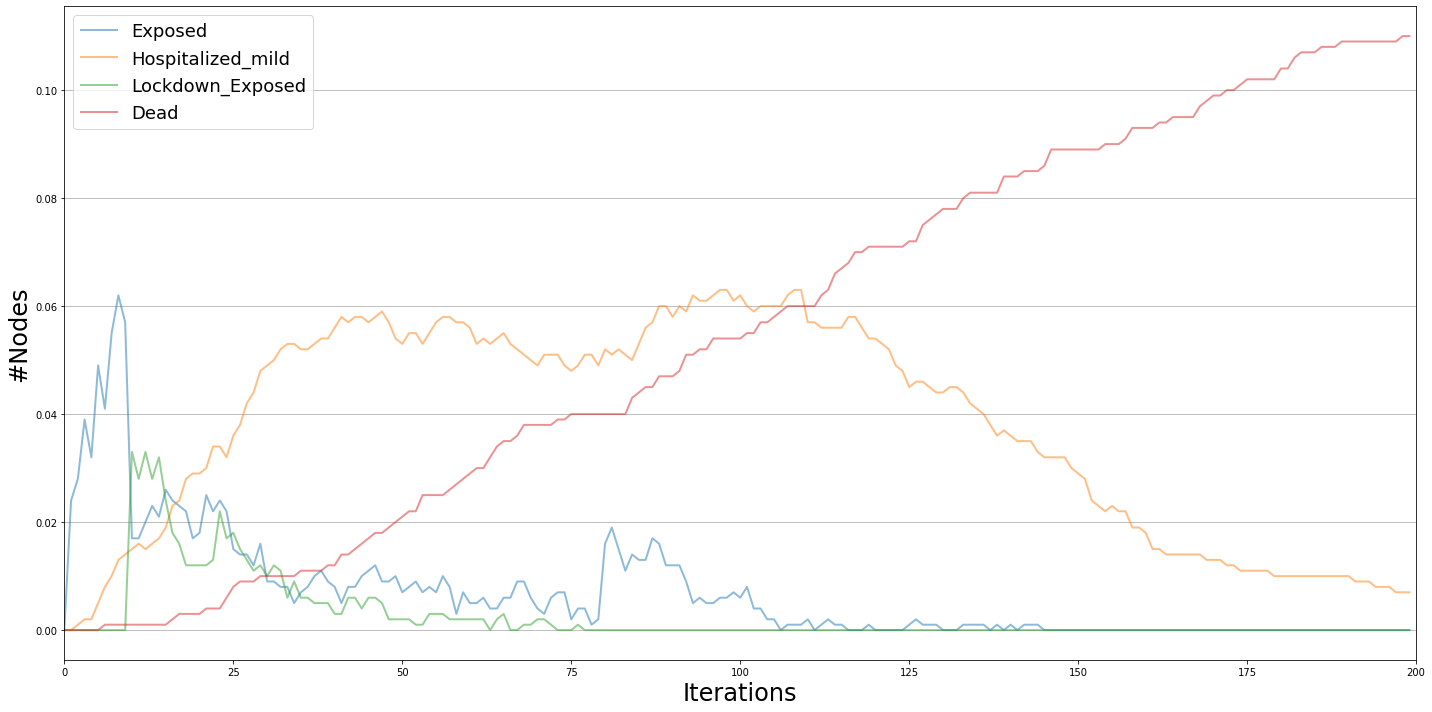

In [28]:
# Model selection
model = ep.UTLDRModel(g)

# Baseline Model Configuration
cfg = mc.Configuration()
beta, sigma, gamma, omega = 0.04, 0.4, 1/40, 0.005
epsilon_e, phi_e, kappa_e, phi_i, kappa_i = 0.9, 0.05, 0.01, 0.05, 0.01
init_infected, number_iters = 0.0001, 150
icu_b = 100 # Available beds
iota = 0.5

# tested recovery rate
gamma_f, gamma_t = 1/200, 1/200

# tested death rate
omega, omega_f, omega_t = 1/1000, 1/50, 1/400

# lockdown
epsilon_l, p_l, lmbd, mu = 3, 0.01, 0.8, 1/70

cfg.add_model_parameter('beta', beta) 
cfg.add_model_parameter('sigma', sigma)
cfg.add_model_parameter('gamma', gamma)

# death probability
cfg.add_model_parameter("omega", omega) 

# Sociality filter due to quarantine
cfg.add_model_parameter("epsilon_e", epsilon_e)
    
# Test Exposed
cfg.add_model_parameter("phi_e", phi_e)
cfg.add_model_parameter("kappa_e", kappa_e)
    
# Test Infected
cfg.add_model_parameter("phi_i", phi_i)
cfg.add_model_parameter("kappa_i", kappa_i)

# ICU and hospitalized death/recovery rate
cfg.add_model_parameter("icu_b", icu_b)
cfg.add_model_parameter("iota", iota)
cfg.add_model_parameter("gamma_f", gamma_f)
cfg.add_model_parameter("gamma_t", gamma_t)
cfg.add_model_parameter("omega_f", omega_f)
cfg.add_model_parameter("omega_t", omega_t)

# Lockdown parameters
cfg.add_model_parameter("epsilon_l", epsilon_l)
    
# Interactions, acceptance & duration
cfg.add_model_parameter("lambda", lmbd)
cfg.add_model_parameter("mu", mu)
    
model.set_initial_status(cfg)
    
# Simulation execution
it = model.iteration_bunch(10)

model.set_lockdown()
it2 = model.iteration_bunch(70)

model.unset_lockdown()
it3 = model.iteration_bunch(120)

it.extend(it2)
it.extend(it3)
trends = model.build_trends(it)

# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=[ 'Exposed', 'Hospitalized_mild', 'Lockdown_Exposed', 'Dead']) 

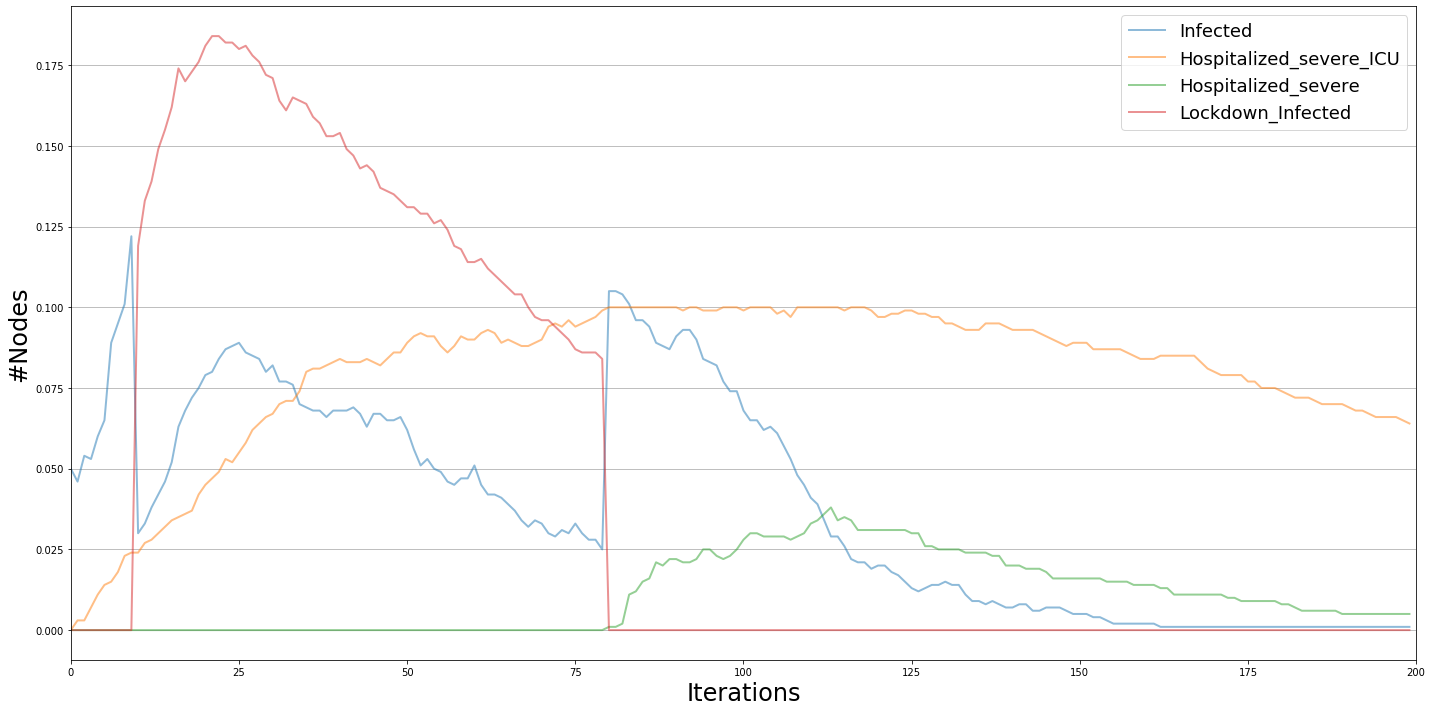

In [29]:
# Visualization
viz = DiffusionTrend(model, trends)
viz.plot(statuses=[ 'Infected', 'Lockdown_Infected', 'Hospitalized_severe', 'Hospitalized_severe_ICU']) 

## 2) Additional compartments

To capture fringe events UTLDR can be easily extended with additional comparments.

In the following we report the transition diagram for a few examples along with the line of code to be added to activate the selected event path.

### a) Corpse Disposal

<img src="img/UTLDR-corpse.png" align="center" />

Adds a probability $z$ of being infected by corpses ($D$) (e.g., a mismanagement of corpse disposal).

In [ ]:
fg.add_model_parameter("z", 0.0001) #z: probability of infection by corpses

### b) Partial Imunization

<img src="img/UTLDR-pi.png" align="center" />

Adds a probability $s$ of re-infection when recovered ($R$).

The transition $R\rightarrow S$ is allowed.

In [ ]:
cfg.add_model_parameter("s", 0.002) #s: probability of reinfection

### c) Vaccination


<img src="img/UTLDRV.png" align="center" />

Adds a probability of vaccination $v$.<br>
Vaccinated agents ($V$) return susceptible with probability $f$.

The transition $S\leftrightarrow V$ and $S_L\leftrightarrow V$ are allowed.

In [ ]:
cfg.add_model_parameter("v", 0.3) #v: probability of vaccination
cfg.add_model_parameter("f", 0.01) #f: probability of nullification (inverse of vaccine duration time)

## 3) Agents Seggmentation and Characterization

So far we applied the proposed framework to a static, not annotated, agents network.

Indeed agents can be better specified by agumenting their behaviors so to provvide a better proxy for a real society.

Here we report a few strategies UTLDR exposes to enforce agents segmentation and characterization.

### a) Activity driven network

In absence of a dynamic contact networks it is possible to make agents interaction vary as time goes by.

To such extent we can assign to each agent an activity rate that models the number of interactions with his neighbors during each iteration.

Moreover, to broaden the interactions introducing casual contacts (e.g., while doing shopping) it is possible to model the probability of long-range interactions as well as their total value per iteration w.r.t. the neighborhood based ones.

In [ ]:
# Imposing activity of an agent per iteration (i.e., ratio of neighbors to being in contact with)
for i in g.nodes:
    config.add_node_configuration("activity", i, np.random.uniform())
    
# Imposing probability of long-range interaction (contacts outside the social circle of an agent)
cfg.add_model_parameter("p", 0.04)

# Imposing number of long-range interactions w.r.t. the ones within the agent social circles
cfg.add_model_parameter("lsize", 0.2)

# Imposing number of long-range interactions w.r.t. the ones within the agent social circles while in lockdown
cfg.add_model_parameter("p_l", 0.04)

### b) Workplace (can be used for any social cirlce)

UTLDR allows to define fine grained lookdown policies by performing selective closing/opening of workplaces as well as schools.

Moreover, it is possible to specify the household for all agents (or even for a subset of them) by passing as input a dictionary that specify the link <agent, list of agents in household>.

In [ ]:
work = ['school', 'PA', 'hospital'] # example of possible works

for i in g.nodes:
    config.add_node_configuration("work", i, np.random.choice(work, 1))

# Example of households partial definition  
households = {0: [1,2,3], 1: [0,2,3], 2: [0,1,3], 3: [0,1,2]}

# selective lockdown set/unset
model.set_lockdown(households, ['PA', 'school'])
model.unset_lockdown(['school'])

### c) Population segmentation (e.g., age or age-gender)

Demograpic information can be used to specify sub-populations for which the model parameters have to be tuned differently.

Such strategy allows, for instance, to assign specific infection/death rate to agents of different ages or gender.

In [ ]:
s_age = ['0-18', '19-65', '65+'] # example of possible age-segments

for i in g.nodes:
    config.add_node_configuration("segment", i, np.random.choice(s_age, 1)[0])
    

# parameter segmentation dependency
config.add_model_parameter("sigma", 0.05)
config.add_model_parameter("beta", {"0-18": 0.01, "19-65": 0.05, '65+': 0.08})
config.add_model_parameter("gamma",{"0-18": 0.08, "19-65": 0.02, '65+': 0.01})
config.add_model_parameter("omega",{"0-18": 0.001, "19-65": 0.01, '65+': 0.02})